In [ ]:
import os
import random
import json
import pickle
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
import librosa.display
from tqdm import tqdm
from google.colab import drive

In [ ]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

drive.mount('/content/drive')

dataset_path = "/content/drive/MyDrive/DataSet/UrbanSound8K/"
audio_path = os.path.join(dataset_path, "audio")
meta_file = os.path.join(dataset_path, "metadata", "UrbanSound8K.csv")

print("dataset_path:", dataset_path)
print("metadata:", meta_file)

Mounted at /content/drive
dataset_path: /content/drive/MyDrive/DataSet/UrbanSound8K/
metadata: /content/drive/MyDrive/DataSet/UrbanSound8K/metadata/UrbanSound8K.csv


In [ ]:
SR = 22050
DURATION = 4.0
MAX_LEN = int(SR * DURATION)
N_MELS = 128
HOP_LENGTH = 512
N_FFT = 2048


def pad_or_trim(signal, target_len):
    if len(signal) < target_len:
        return np.pad(signal, (0, target_len - len(signal)), mode="constant")
    return signal[:target_len]


def extract_mel(path):
    y, _ = librosa.load(path, sr=SR, mono=True)
    y = pad_or_trim(y, MAX_LEN)

    S = librosa.feature.melspectrogram(
        y=y, sr=SR, n_mels=N_MELS,
        hop_length=HOP_LENGTH, n_fft=N_FFT
    )

    S_db = librosa.power_to_db(S, ref=np.max)
    return S_db.astype(np.float32)

In [ ]:
metadata = pd.read_csv(meta_file)
print("Entradas:", len(metadata))

X_list, y_list, folds_list = [], [], []


Entradas: 8732


In [ ]:
for _, row in tqdm(metadata.iterrows(), total=len(metadata), desc="Procesando audio"):
    fold = int(row["fold"])
    fname = row["slice_file_name"]
    class_id = int(row["classID"])

    file_path = os.path.join(audio_path, f"fold{fold}", fname)
    mel = extract_mel(file_path)

    X_list.append(mel)
    y_list.append(class_id)
    folds_list.append(fold)

# Convertir a arrays
X = np.array(X_list, dtype=np.float32)  # [N, n_mels, n_frames]
y = np.array(y_list, dtype=np.int32)
folds = np.array(folds_list, dtype=np.int32)

# Añadir canal
X = X[..., np.newaxis]

print("X:", X.shape)
print("y:", y.shape)


Procesando audio: 100%|██████████| 8732/8732 [57:15<00:00,  2.54it/s]


X: (8732, 128, 173, 1)
y: (8732,)


In [ ]:
train_idx = np.isin(folds, list(range(1, 9)))
X_train_only = X[train_idx]

mean = np.mean(X_train_only)
std = np.std(X_train_only)

print("mean:", mean)
print("std:", std)

X_norm = (X - mean) / (std + 1e-8)


mean: -42.301918
std: 20.748253


In [ ]:
class_map = metadata[['classID', 'class']].drop_duplicates().sort_values('classID')
class_names_ordered = list(class_map["class"].values)

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(class_names_ordered)

y_names = [class_names_ordered[int(ci)] for ci in y]
y_encoded = le.transform(y_names)


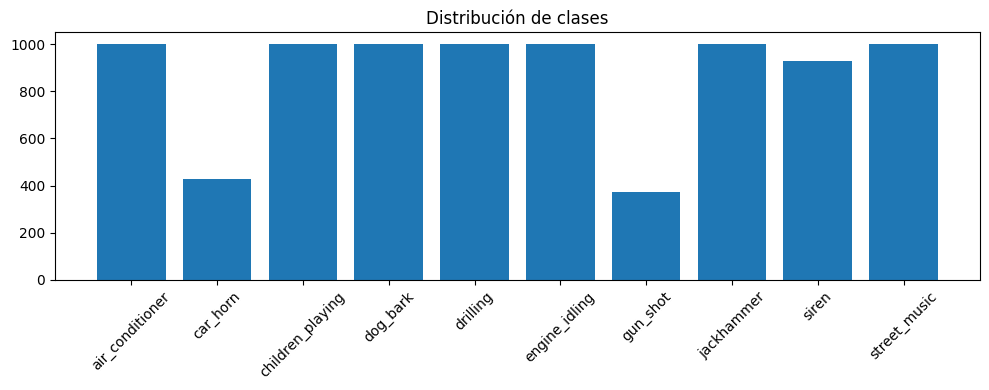

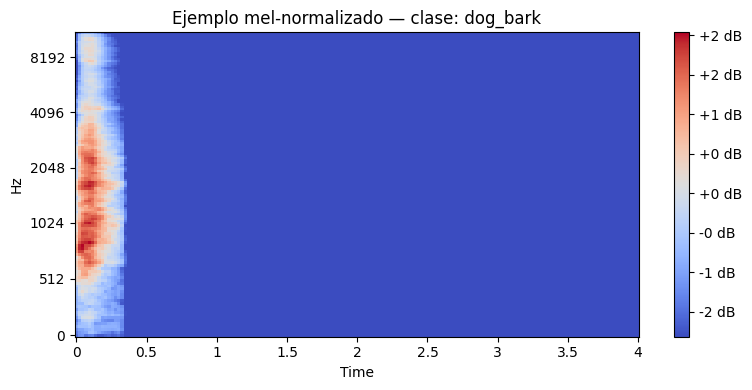

In [ ]:
unique_ids, counts = np.unique(y, return_counts=True)
plt.figure(figsize=(10, 4))
plt.bar(unique_ids, counts)
plt.xticks(unique_ids, class_names_ordered, rotation=45)
plt.title("Distribución de clases")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
mel_example = X_norm[0, :, :, 0]
librosa.display.specshow(
    mel_example, sr=SR, hop_length=HOP_LENGTH,
    x_axis="time", y_axis="mel"
)
plt.colorbar(format="%+2.0f dB")
plt.title(f"Ejemplo mel-normalizado — clase: {class_names_ordered[y[0]]}")
plt.tight_layout()
plt.show()


In [ ]:
out_dir = "/content/drive/MyDrive/UrbanSound_Preprocessed"
os.makedirs(out_dir, exist_ok=True)

np.save(os.path.join(out_dir, "X_mel.npy"), X_norm.astype(np.float32))
np.save(os.path.join(out_dir, "y_labels.npy"), y_encoded)
np.save(os.path.join(out_dir, "folds.npy"), folds)

with open(os.path.join(out_dir, "label_encoder.pkl"), "wb") as f:
    pickle.dump(le, f)

params = {
    "sr": SR,
    "duration": DURATION,
    "max_len": MAX_LEN,
    "n_mels": N_MELS,
    "hop_length": HOP_LENGTH,
    "n_fft": N_FFT,
    "input_shape": list(X_norm.shape[1:]),
    "class_names": class_names_ordered,
    "seed": SEED,
    "mean": float(mean),
    "std": float(std)
}

with open(os.path.join(out_dir, "preprocessing_params.json"), "w") as f:
    json.dump(params, f, indent=2)
